# Análisis a bloques. Afinador continuo

En los cuadernos anteriores
* Seleccionábamos un bloque *a mano*
* Calculábamos la FFT
* Buscábamos la frecuencia fundamental
* Decíamos a qué cuerda correspondía y el error en semitonos

En este cuaderno, en vez de seleccionar el bloque a mano, iremos cogiendo bloques correlativos con un solape del 50%. Para cada bloque obtendremos:
* Cuerda más probable
* Error en semitonos
* Potencia asignable a la nota


In [2]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore') # Para quitar mensajes de warning
import upv_audio 
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)

In [3]:
### FUNCIONES DE CUADERNOS ANTERIORES
def calculaFFT(x, NFFT=None):
    
    # Si no damos NFFT es directamente la longitud de la señal
    if NFFT==None:
        NFFT = len(x) 
       
    # Comprobamos que NFFT sea mayor que la longitud de x.
    assert len(x)<=NFFT, 'NFFT tiene que ser mayor o igual a que len(x)'

    # Calculamos la FFT
    X = np.abs(np.fft.fft(x,NFFT))*2/len(x) # FFT rellena con ceros desde L a NFFT y la normalizamos (*2/len(x))   
    X = X[0:NFFT//2]
    
    # Generamos el eje de frecuencia digital
    fd = np.arange(0, NFFT)/NFFT
            
    return X, fd[0:NFFT//2]




def determina_frecuencia_fundamental(X,f_analog,fmin,fmax): 
    '''
    X espectro de amplitudes tal como lo devuelve calculaFFT
    f_analog f*fs, donde f es frecuencia digital devuelta por calculaFFT
    
    fmin,fmax, rango de frecuencias fundamentales    '''
    
    #Numero máximo de armónicos a considerar
    K=4
    
    # Calcular los valores de kmin, kmax que corresponden al rango de frecuencias fmin, fmax
    # recordar que kmin y kmax son valores enteros (emplear round)
    kmin = np.max(np.argwhere(f_analog<fmin*K))
    kmax = np.min(np.argwhere(f_analog>fmax*K))
    
    # Recorremos el rango de frecuencias entre kmin y kmax (fmnin y fmax)
    max_val=0
    best_fundamental =0
    for n in np.arange(kmin, kmax):
        
        fundamental = float(n)/float(K)
        ind = fundamental * np.arange(1,K+1) # Índices donde están los armónicos  
        ind = np.round(ind).astype('int')
        val = np.prod((X[ind]))  # HPS: Harmonic Product Spectrum
        
        if (val > max_val):
            max_val = val
            best_fundamental = f_analog[n]/K                     
    
    #Devolvemos la frecuencia con la amplitud máxima acumulada
    return best_fundamental, max_val




def cuerda_y_error(f0,f_cuerdas):
    '''
    f0: frecuencia fundamental
    f_cuerdas Vector con las frecuencias nominales de las cuerdas.
    '''
    
    dist_semitonos = 12.0 * (math.log2(f0)-np.log2(f_cuerdas))
    cuerda = 1 + np.argmin(np.abs(dist_semitonos))
    error=dist_semitonos[cuerda-1]
    
    return cuerda, error

In [4]:
# Función nueva. Es simple integración de todo lo anterior
def analisis_bloque(trozo,fs):
    '''
    analisis_bloque(trozo,fs)
    Recibe un trozo de señal y su correspondiente fs
    Devuelve:
        cuerda pulsada: 1--6
        error: de afinación en semitonos
        potencia: Es la potencia de trozo. Sirve para descartar fragmentos donde no haya sonido
        fundamental: Frecuencia fundamental en hz.
    '''
    NFFT=2**math.ceil(math.log2(2*len(trozo)))
    trozow=trozo*signal.hanning(len(trozo))
    X,f=calculaFFT(trozo,NFFT)
    f_analog = f* fs
    
    f_cuerdas  = np.array([329.63, 246.94, 196.00, 146.8, 110, 82.41])
    
    fundamental,_=determina_frecuencia_fundamental(X,f_analog,np.min(f_cuerdas)*0.9,np.max(f_cuerdas)*1.1) 
    potencia_nota = np.var(trozo)
    cuerda,error = cuerda_y_error(fundamental,f_cuerdas)
    
    
    return cuerda, error, potencia_nota,fundamental

In [5]:
# Prueba de analisis_bloque
fs,x2=upv_audio.read('audios/guitarra/c2.wav')
duracion = int(0.2*fs)
ini2=40000
fin2=ini2+duracion
trozo2=x2[ini2:fin2]

In [6]:
print( analisis_bloque(trozo2,fs))

(2, 0.07194129181480946, 0.006294287524311064, 247.96829223632812)


In [7]:
fs,x4=upv_audio.read('audios/guitarra/c4.wav')
duracion = int(0.2*fs)
ini4=40000
fin4=ini4+duracion
trozo4=x4[ini4:fin4]

In [8]:
print( analisis_bloque(trozo4,fs))

(4, -0.012393574160146414, 0.004438991422517105, 146.6949462890625)


In [9]:
def analisis_continuo(audio,fs,dur_bloque):
    '''
    Realiza el análisis para determinar la frecuencia fundamental en cada bloque.
    Para cada bloque devuelve:
    cuerda. Valor de 1 a 6 de la cuerda estimada
    error: de afinación en semitonos.
    potencia del bloque
    dif_pot. Diferencia de potencia con el bloque previo. Para evitar el ataque, 
      los bloques en los que nos fijaremos son en los que la señal vaya decayendo
    
    
    
    '''
    #print('fs=',fs)
    #print('dur_bloque=',dur_bloque)
    duracion_muestras = int(dur_bloque*fs)
    avance = duracion_muestras // 4
    
    nmues = len(audio)
    ini=0
    fin=ini+duracion_muestras
    cuerdas=[]
    errores=[]
    potencias=[]
    fundamentales=[]
    difs_pot=[]
    contador=0
    while fin < nmues:
       # print(ini,fin)
        trozo = audio[ini:fin]
        cuerda,err,potencia,fundamental = analisis_bloque(trozo,fs)
        cuerdas.append(cuerda)
        errores.append(err)
        potencias.append(potencia)
        fundamentales.append(fundamental)
        pot_log=10*math.log10(potencia)
        if contador >0:
            dif_pot = potencias[-1] -potencias[-2]
        else:
            dif_pot = 0
        difs_pot.append(dif_pot)
        #print(contador,ini,fin,pot_log,dif_pot,fundamental)
        ini += avance
        fin += avance
        contador +=1
    cuerdas = np.array(cuerdas)
    errores = np.array(errores)
    potencias = np.array(potencias)
    fundamentales=np.array(fundamentales)
    difs_pot = np.array(difs_pot)
    
    return cuerdas,errores,potencias,fundamentales,difs_pot

In [10]:
fs,audio=upv_audio.read('audios/guitarra/afinadas_y_separadas_8k.wav')
#fs,audio=upv_audio.read('audios/guitarra/seis_cuerdas_8k.wav')

In [11]:
cuerdas,errores,potencias,fundamentales,difs_pot=analisis_continuo(audio,fs,0.5)

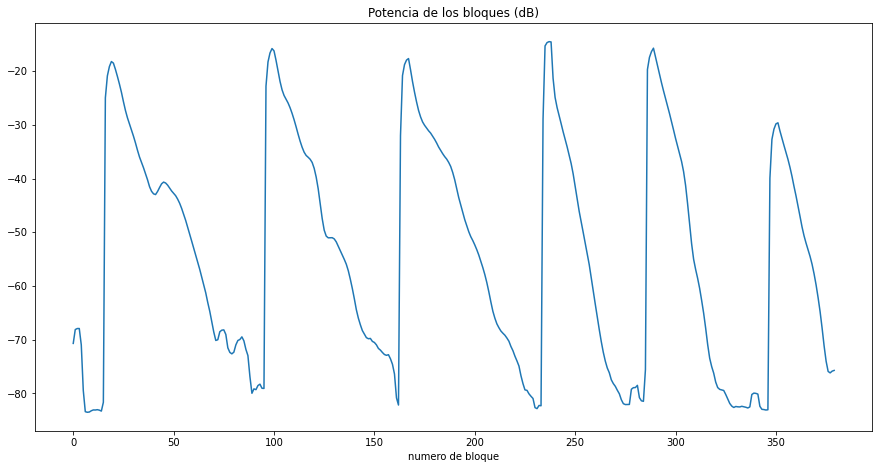

In [16]:
# Representaremos la potencia de cada bloque en escala logarítmica.
# Si la potencia es demasiado pequeña, el afinador debe devolver "sin señal"


_=plt.plot(10*np.log10(potencias))
_=plt.title('Potencia de los bloques (dB)')
_=plt.xlabel('numero de bloque')

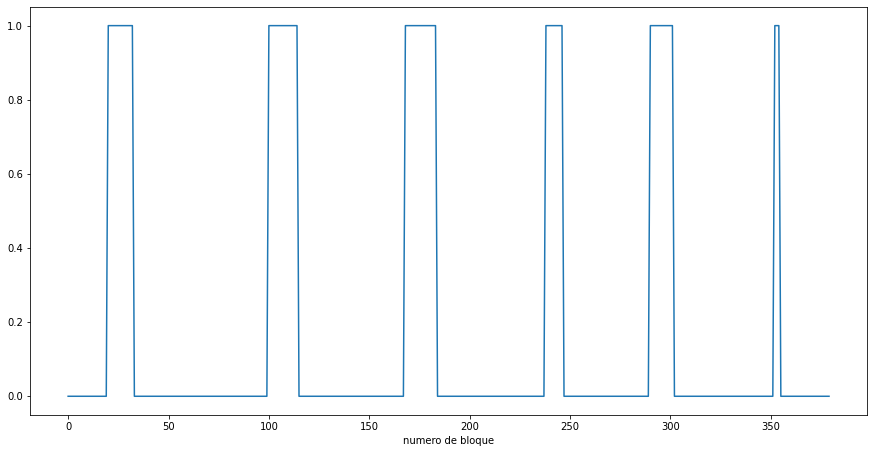

In [15]:
# Los bloques de interés son los que tienen suficiente potencia y además la potencia es menor que en el bloque
# previo (evitar el ataque)
mascara =((10*np.log10(potencias)> -35)*(difs_pot < 0)).astype('float')
_=plt.plot(mascara)
_=plt.xlabel('numero de bloque')

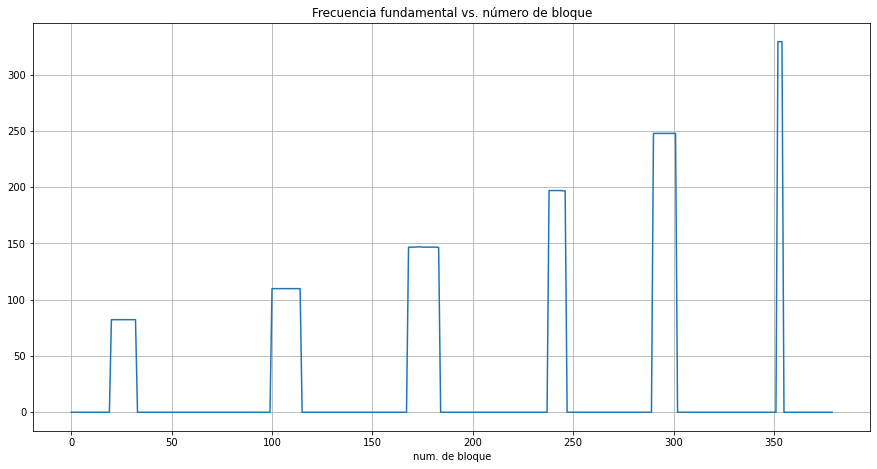

In [17]:
_=plt.plot(fundamentales*mascara)
_=plt.grid()
_=plt.title('Frecuencia fundamental vs. número de bloque')
_=plt.xlabel('num. de bloque')

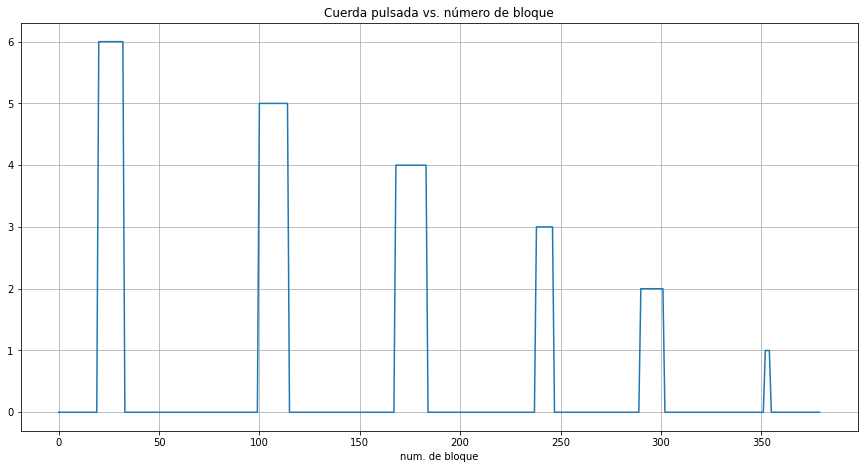

In [18]:
_=plt.plot(cuerdas*mascara)
_=plt.grid()
_=plt.title('Cuerda pulsada vs. número de bloque')
_=plt.xlabel('num. de bloque')

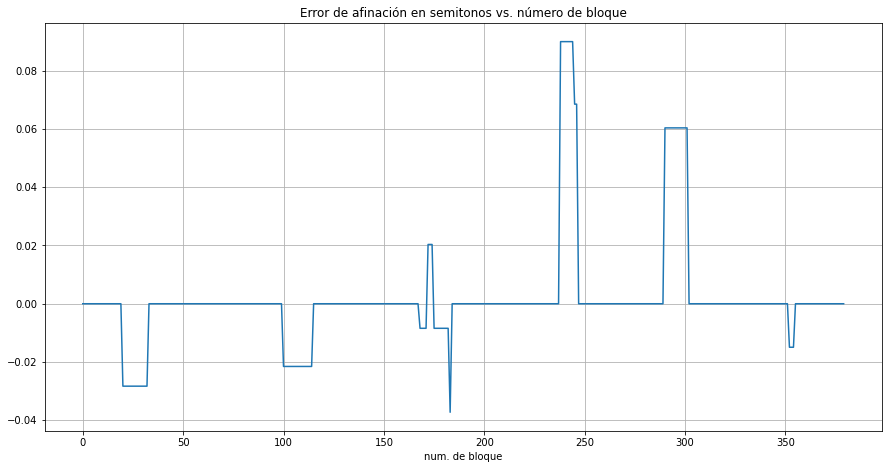

In [19]:
_=plt.plot(errores*mascara)
_=plt.grid()
_=plt.title('Error de afinación en semitonos vs. número de bloque')
_=plt.xlabel('num. de bloque')

**Observaciones**
* Hemos encontrado un buen criterio para saber qué fragmentos de señal son interesantes
* En todos los bloques válidos se estima bien tanto la frecuencia fundamental como la cuerda
* Esta guitarra... ¡ Está bien afinada !!